In [2]:
'''
Reference:
https://marcobonzanini.com/2015/03/02/mining-twitter-data-with-python-part-1/
'''

'\nReference:\nhttps://marcobonzanini.com/2015/03/02/mining-twitter-data-with-python-part-1/\n'

In [2]:
#for computer room 

#import nltk
#nltk.download('punkt')
#nltk.download('stopwords')

import json
import nltk
from nltk import word_tokenize
import re
from nltk.corpus import stopwords
import string
import numpy as np 
import pandas as pd
import sklearn

# The Anatomy of a Tweet

In [ ]:
# 單個Tweet裡所包含的所有資訊
import json
with open('Cry.json', 'r') as f:
    line = f.readline()
    tweet = json.loads(line)
    print(json.dumps(tweet, indent=4))
    

In [4]:
#tweet usually in unicode -> transform
enc = tweet['text'].encode('unicode-escape')

#the tweet be divided into too seperate
import re

emoticons_str = r'''
    (?:
        [:=;] #eye
        [oO\-] #nose
        [D\)\]\)\]/\\OpP] #mouth
    )'''

regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
    
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]

#re.compile(pattern) comile the pattern of re.
#ref: http://zwindr.blogspot.jp/2016/01/python-regular-expression.html
tokens_re = re.compile(r'(' + '|'.join(regex_str) + ')', re.X |re.I)
emoticon_re = re.compile(r'^' + emoticons_str + '$', re.X | re.I)
#I -> ignorance: take the lowercase and uppercase as same
#X -> Verbose: make a re. more readable, ignore the '#' explantion


def tokenize(s):
    return tokens_re.findall(s)

def preprocess(s, lowercase=False):
    tokens = tokenize(s.encode('unicode-escape'))
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower for token in tokens]
    return tokens

    
#re.search:Scan through string looking for the first 
#      location where the regular expression pattern 
#      produces a match

#### 目前已完整分解字詞，並可獨立出emoji，接下來做成dataframe

In [5]:
word_list = []
with open('Cry.json') as f:
    for line in f:
        tweet = json.loads(line)
        text = tweet['text'].encode('unicode-escape')
        words = preprocess(text) 
        word_list.append(words)

from itertools import chain
word_list = list(chain.from_iterable(word_list))
word_list = [word.lower() for word in word_list] #斷完詞後的"所有"詞跟符號

### Build dataframe of each word and emoji 
### Take the unique word and emoji from tweet 

In [6]:
from nltk.corpus import stopwords
import string

punctuation = [string.punctuation]
stop_uni = stopwords.words('english') + punctuation + ['rt','via']

stop = [word.encode('ascii') for word in stop_uni]    
word_stop = [word for word in word_list 
            if word not in stop and
                    not word.startswith(
    ('u0','http','@','#','\\','/','*','-','{','}','[',']','(',')',
     '+','x',':',"''",'i\\','.','?','!',"'",'"',',',';',':','&',''
     'u2','ua','ub','uc','ud')) and
                    not word.isdigit()]
emoji = [emoji[:9] for emoji in word_list #there's a case is u000f162somebody
             if emoji.startswith(('u000'))]

In [6]:
#build the dataframe
word_single = list(set(word_stop))
emoji_single = list(set(emoji))

word_single = sorted(word_single)

## Method1: Freq to build dataframe

In [10]:
import nltk
from nltk import word_tokenize
from nltk.probability import FreqDist
import pandas as pd

def text_process(text):
    
    enc = text.encode('unicode-escape')
    pro_text = preprocess(enc)

    #[emoji for emoji in pro_text if emoji.startswith('U000')]
    stop_tuple = ('u00','http','@','#','\\','/','*','-','{','}','[',']','+','x',':',"''",'i\\','.','?','!',"'",'"',
     ',',';',':','&',''
     'u2','ua','ub','uc','ud')
    emoji_list = [emoji.lower() for emoji in pro_text if emoji.startswith('U00')]
    pro_text = [word.lower() for word in pro_text if word not in stop #'in', so 'word not in'
                            and not word.startswith(stop_tuple)
                            and not word.isdigit()
                            and not len(word) < 2]
    return emoji_list, FreqDist(pro_text)

In [11]:
import json
import numpy as np
cry_list = []

with open('Cry.json', 'r') as f:
    for line in f:
        tweet = json.loads(line)
        emoji_list, pro_text = text_process(tweet['text'])
        cry_list.append([emoji_list, pro_text])
        #df = merge_dataframe(emoji_list, pro_text, df_emoji)

#cry_list

# Method2: Use For Loop to loop each sentence 

In [7]:
import nltk
from nltk import word_tokenize

def text_process_simple(text):
    
    enc = text.encode('unicode-escape')
    pro_text = preprocess(enc)

    #[emoji for emoji in pro_text if emoji.startswith('U000')]
    stop_tuple = ('U000','RT','@',':','/','\\''','.','u2','http','u0','#','xf','xe','('
                 'ua','ub','uc','ud',';','_','aa',
                  '1','2','3','4','5','6','7','8','9','0')
    emoji_list = [emoji.lower()[:9] for emoji in pro_text if emoji.startswith('U00')
                 ]
    pro_text = [word.lower() for word in pro_text]
    pro_text = [word.lower() for word in pro_text if not word.startswith(stop_tuple)
                            and word not in stop
                            and not word.isdigit()
                            and not len(word) < 2
                            and not len(word) > 15]
    return emoji_list, pro_text

In [8]:
import json
import numpy as np
cry_list = []

with open('Cry.json', 'r') as f:
    for line in f:
        tweet = json.loads(line)
        emoji_list, pro_text = text_process_simple(tweet['text'])
        cry_list.append([emoji_list, pro_text])
        #df = merge_dataframe(emoji_list, pro_text, df_emoji)

#for i in cry_list:
#    for j in i[0]:
#        first_df.loc[i[1],j] += 1

In [13]:
import json
emo_list = []

with open('Emoji.json') as f:
    for line in f:
        tweet = json.loads(line)
        if len(tweet) > 20:
            emoji_list, pro_text = text_process_simple(tweet['text'])
            emo_list.append([emoji_list, pro_text])
            #print(preprocess(tweet['text']))
            #print(tweet['text'])

In [ ]:
# word_single = []
emoji_single = []

for i in range(len(emo_list)):
    word_single.append(emo_list[i][1])
    emoji_single.append(emo_list[i][0])
    
word_single = list(sorted(set([word for word_list in word_single 
                        for word in word_list])))
emoji_single = list(set([emoji for emoji_list in emoji_single 
                              for emoji in emoji_list]))

In [45]:
#build the dataframe
emoji_df = pd.DataFrame([np.zeros(len(emoji_single), dtype=np.int64)], 
            columns = emoji_single, index = word_single)

for i in emo_list:
    for j in i[0]:
        #print(emoji_df.loc[i[1], j])
        emoji_df.loc[i[1],j] += 1

In [15]:
emoji_list = [emoji.lower() for emoji in emoji_list]

#only emoji 6XX series
face_df = emoji_df[emoji_df.columns[emoji_df.columns.isin(emoji_list)]]

NameError: name 'emoji_df' is not defined

In [18]:
emoji_df = pd.read_csv('/Users/hsnu130427/Twitter/Code/emoji_df.csv')

,Unnamed: 0,445,98b,3df,48a,3dd,5a5,5a4,918,601,...,346,502,503,478,4c5,6ab,4b5,46f,35f,51e
0,ab,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,abarklk,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,abby,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,abc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,abetting,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, copy=True,whiten=True)
newdata = pca.fit_transform(emoji_df.T)

array([[ -9.07985662e-02,  -1.60733269e-01,  -1.02204439e-02],
       [ -1.02833248e-01,  -1.67261636e-01,  -5.16079795e-02],
       [ -9.93645302e-02,  -1.20207544e-01,  -8.81633725e-02],
       [ -1.04081613e-01,  -1.83765609e-01,  -4.45209185e-02],
       [ -1.02934411e-01,  -1.72862305e-01,  -5.11951075e-02],
       [ -1.02912324e-01,  -1.70485947e-01,  -5.15248924e-02],
       [ -9.71712883e-02,  -1.53717499e-01,  -1.94399173e-02],
       [ -9.83182578e-02,  -1.60464968e-01,  -1.69283154e-02],
       [  1.29879372e-01,   1.72365506e-01,  -1.42967425e-01],
       [ -1.03788406e-01,  -1.83696163e-01,  -4.43730668e-02],
       [ -8.47707155e-02,  -1.39400276e-01,  -4.60439848e-02],
       [  1.59801772e+01,  -1.84635865e+00,  -3.56187591e-01],
       [ -7.46517779e-02,  -1.41802096e-01,  -2.84842006e-02],
       [ -3.76802433e-02,  -1.06159623e-01,  -1.11038786e-02],
       [ -9.77168764e-02,  -1.57701995e-01,  -3.38202540e-02],
       [  1.38228572e-02,   6.23442709e-01,  -5.3229256

In [57]:
ratio = pca.explained_variance_ratio_
cumulative = 0

for i in range(len(ratio)):
    cumulative += ratio[i]
    print('Cumulative ratio until ' + str(i+1) + 'th component,: ' + str(cumulative) )
    

Cumulative ratio until 1th component,: 0.403841040189
Cumulative ratio until 2th component,: 0.516414779632
Cumulative ratio until 3th component,: 0.607084143771


### Emoji as columns, word as rows 

In [75]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2,random_state=0).fit_transform(emoji_df)
tsne_df = pd.DataFrame(tsne, columns = ['dim1', 'dim2'])

In [ ]:
tsne_df.to_csv('tsne_word_as_row.csv')

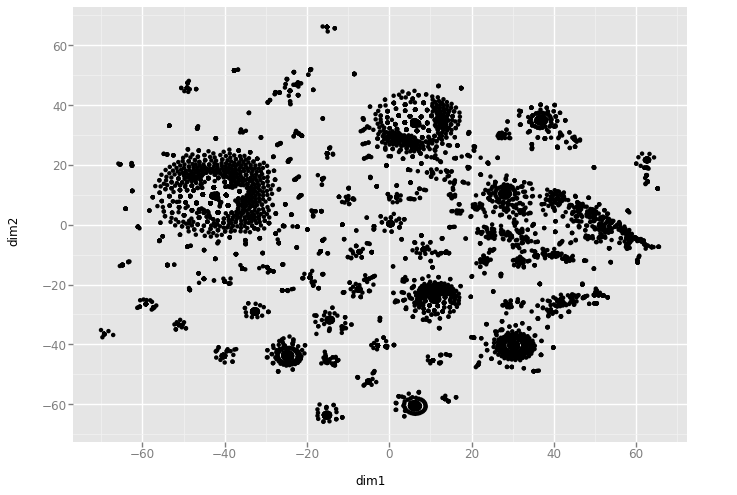

<ggplot: (7022028897)>

In [77]:
#tsne_df = pd.read_csv()
ggplot(tsne_df, aes(x='dim1',y='dim2')) + geom_point()

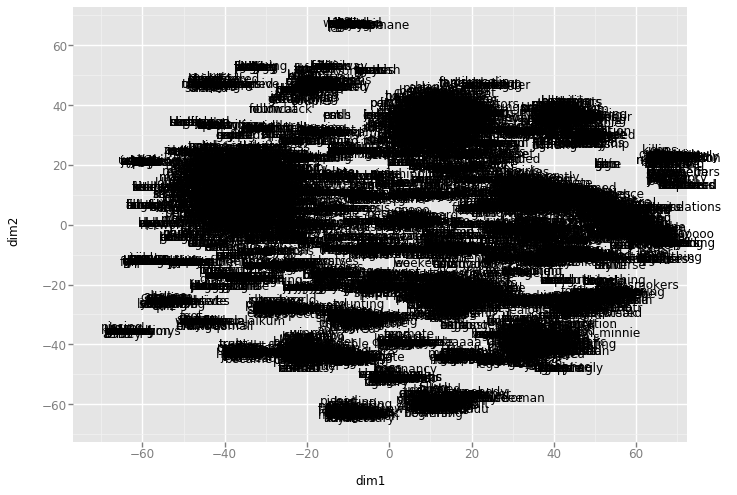

<ggplot: (7026015361)>

In [82]:
tsne_df['Word'] = emoji_df.index
ggplot(tsne_df,aes(x='dim1',y='dim2',label = 'Word')) +\
    geom_text()

In [61]:
#Reduce with PCA
pca_trans = PCA(n_components=2, copy=True)
trans_emoji = pca_trans.fit_transform(emoji_df.T)

from ggplot import *

emoji_pca = pd.DataFrame(trans_emoji, 
                         columns = ['dim1', 'dim2'],
                         index = emoji_df.columns)
ggplot(emoji_pca, aes(x='dim1',y='dim2')) +\
    geom_point() +\
    ylim(-10,30) +\
    xlim(-6,5)

array([[ -4.45636127e+00,  -4.16505266e+00],
       [ -5.04701917e+00,  -4.33422108e+00],
       [ -4.87677573e+00,  -3.11491676e+00],
       [ -5.10828848e+00,  -4.76188560e+00],
       [ -5.05198419e+00,  -4.47935022e+00],
       [ -5.05090018e+00,  -4.41777208e+00],
       [ -4.76913220e+00,  -3.98325428e+00],
       [ -4.82542505e+00,  -4.15810023e+00],
       [  6.37443327e+00,   4.46647680e+00],
       [ -5.09389796e+00,  -4.76008606e+00],
       [ -4.16051650e+00,  -3.61225462e+00],
       [  7.84301399e+02,  -4.78443640e+01],
       [ -3.66388265e+00,  -3.67449255e+00],
       [ -1.84933291e+00,  -2.75089547e+00],
       [ -4.79590947e+00,  -4.08650381e+00],
       [  6.78420905e-01,   1.61551603e+01],
       [  2.80623032e+01,   1.29739518e+02],
       [  3.66064992e-01,  -8.93680825e-01],
       [ -4.82321496e+00,  -4.43343877e+00],
       [ -4.96747032e+00,  -4.64433163e+00],
       [ -4.79533802e+00,  -3.31789169e+00],
       [ -5.04701917e+00,  -4.33422108e+00],
       [ -

In [177]:
#Reduce with t-SNE
from sklearn.manifold import TSNE

tsne_T = pd.DataFrame(TSNE(n_components=2,random_state=0).fit_transform(emoji_df.T), columns=['dim1','dim2'])

In [ ]:
ggplot(tsne_T, aes(x='dim1',y='dim2')) + geom_point()

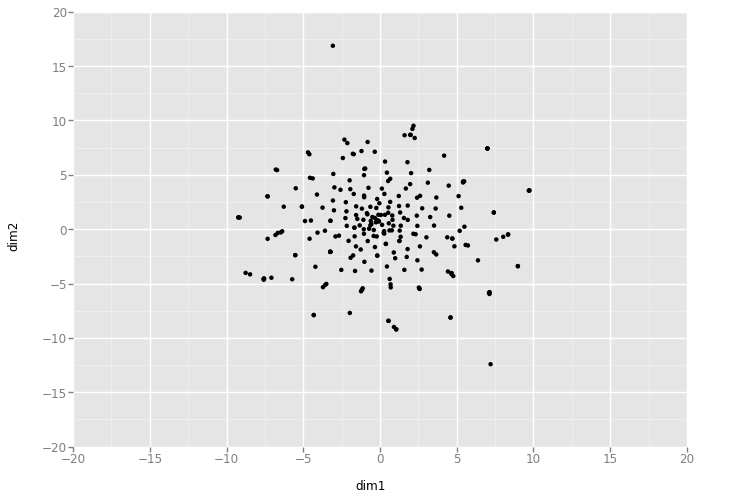

<ggplot: (7009129529)>

In [195]:
ggplot(tsne_T, aes(x='dim1',y='dim2')) +\
    geom_point() +\
    xlim(-20, 20) + ylim(-20,20) 

In [2]:
print(u"\U0001F914")

🤔


### Reduce the dimension of Y 

In [66]:
#Count the freq for each emoji(column)

col_sum = emoji_df.iloc[:,2:].apply(sum,axis=0) 
#col_sum.sort_values(ascending=False)


In [9]:
import nltk
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer

def text_process_simple(text):
    
    enc = text.encode('unicode-escape')
    pro_text = preprocess(enc)

    #[emoji for emoji in pro_text if emoji.startswith('U000')]
    stop_tuple = ('U000','RT','@',':','/','\\''','.','u2','http','u0','#','xf','xe','('
                 'ua','ub','uc','ud',';','_','aa','=',
                  '1','2','3','4','5','6','7','8','9','0')
                
    #pro_text = [word.lower() for word in pro_text]
    pro_text = [word.lower() for word in pro_text if not word.startswith(stop_tuple)
                            and word not in stop
                            and any(char.isdigit() for char in word) == False
                            and not word.isdigit()
                            and "'" not in set(word)
                            and not len(word) < 2
                            and not len(word) > 15]
    
    stemmer = SnowballStemmer('english')
    pro_text = [stemmer.stem(word) for word in pro_text]
    pro_text = [word.encode('utf-8') for word in pro_text]
    
    return pro_text

### Huge data preprocessing
    segment the sentence into [Emoji_type,word_list] 
    spilt the training & testing
    combine all word from training into big dataframe 
    train neural network
    test with test data
    tuning


In [20]:
#crying
import json
crying_list = []

with open('Crying_62d.json') as f:
    for line in f:
        tweet = json.loads(line)
        if len(tweet) > 20:
            pro_text = text_process_simple(tweet['text'])
            pro_text.append('Label_Crying') #有改過，所以下面用single的可能會變
            crying_list.append(pro_text)
            
crying_list_copy = crying_list

heart_list = []

with open('heart_eye_60d.json') as f:
    for line in f:
        tweet = json.loads(line)
        if len(tweet) > 20:
            pro_text = text_process_simple(tweet['text'])
            pro_text.append('Label_Heart')
            heart_list.append(pro_text)

heart_list_copy = heart_list

tear_joys_list = []

with open('Tear_Joys_602.json') as f:
    for line in f:
        tweet = json.loads(line)
        if len(tweet) > 20:
            pro_text = text_process_simple(tweet['text'])
            pro_text.append('Label_Tear_Joys')
            tear_joys_list.append(pro_text)
tear_joys_list_copy = tear_joys_list
            
total_length = len(crying_list) + len(tear_joys_list) + len(heart_list) 

In [21]:
#crying_single
crying_single = []

for i in range(len(crying_list)):
    crying_single.append(crying_list[i])
    
crying_single = list(sorted(set([word for crying_list in crying_single 
                        for word in crying_list])))
crying_single.remove('Label_Crying')

#after run this cell, crying_list became ['retweet', 'Label of crying']

In [22]:
#heart_single
heart_single = []

for i in range(len(heart_list)):
    heart_single.append(heart_list[i])
    
heart_single = list(sorted(set([word for heart_list in heart_single 
                        for word in heart_list])))
heart_single.remove('Label_Heart')


In [23]:
#tear_joys_single
tear_joys_single = []

for i in range(len(tear_joys_list)):
    tear_joys_single.append(tear_joys_list[i])
    
tear_joys_single = list(sorted(set([word for tear_joys_list in tear_joys_single 
                        for word in tear_joys_list])))
tear_joys_single.remove('Label_Tear_Joys')


In [15]:
all_single = [crying_single, tear_joys_single, heart_single]
all_single = list(sorted(set([word for word_list in all_single 
                        for word in word_list])))

word_columns = np.append(all_single, ['Label_Crying', 'Label_Tear_Joys', 'Label_Heart'])
word_columns

array(['a-ar', 'a-ha', 'a-nat', ..., 'Label_Crying', 'Label_Tear_Joys',
       'Label_Heart'],
      dtype='|S15')

In [16]:
#Before run this, run the tokenzize of json file above again

df = pd.DataFrame(data= np.zeros((total_length,len(word_columns)), dtype=np.int8), 
             index = range(total_length),columns = word_columns)

In [17]:
for i in range(len(crying_list_copy)):
    for j in crying_list_copy[i]:
        df.loc[i,j] += 1

In [18]:
df.head()

,a-ar,a-ha,a-nat,a____jin,a_za,aaaaa,aaaaaaa,aaaaaaaa,aaaaaah,aaaaabitch,...,zvgdik,zwu,zxqh,zxtjvi,zyada,zyrldywu,zzo,Label_Crying,Label_Tear_Joys,Label_Heart
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [24]:

for i in range(len(tear_joys_list_copy)):
    for j in tear_joys_list_copy[i]:
        df.loc[len(crying_list_copy)+i,j] += 1

for i in range(len(heart_list_copy)):
    for j in heart_list_copy[i]:
        df.loc[len(crying_list_copy) + len(tear_joys_list_copy) + i,j] += 1

In [25]:
#把出現不到5次的拔掉
mask = df.apply(sum,axis=0) > 4 #df.sum(1)
reduced_df = df.loc[:, mask]

In [26]:
simplified_list = reduced_df.iloc[:,1:].columns.values

In [29]:
reduced_df.to_csv('Three_Emoji_Simplified_root.csv')

In [27]:
len(simplified_list)

5550

### Prepare the testing data 

In [30]:
# Test data
# each json to word_list
# compare to all single
# keep those words in all single
# fill in the dataframe with each entries  
# combine together
# save as csv

import json
test_crying_list = []

with open('Test_62d_1.json') as f:
    for line in f:
        tweet = json.loads(line)
        if len(tweet) > 20:
            pro_text = text_process_simple(tweet['text'])
            pro_text.append('Label_Crying') #有改過，所以下面用single的可能會變
            test_crying_list.append(pro_text)  
            
test_crying_list_copy = test_crying_list
            
test_crying_df = pd.DataFrame(
        np.zeros((len(test_crying_list), len(simplified_list)), 
        dtype = np.int8), 
             columns = simplified_list)

In [31]:
test_crying_single = []

for i in range(len(test_crying_list)):
    test_crying_single.append(test_crying_list[i])
    
test_crying_single = list(sorted(set([word for test_crying_list in test_crying_single 
                        for word in test_crying_list])))
test_crying_single.remove('Label_Crying')

In [32]:
not_in_list = 0

for i in range(len(test_crying_list_copy)):
    for j in test_crying_list_copy[i]:
        if j in simplified_list:
            test_crying_df.loc[i,j] += 1
        else:
            not_in_list += 1

print('Total word count: ' + str(len(test_crying_single)))

print('Word not in list: ' + str(not_in_list))

Total word count: 3409
Word not in list: 1332


In [213]:
test_heart_df.head()

,a_za,ab,abandoned,abdelh,ability,able,abolishing,abominable,abortion,abou,...,zhang's,zico,zkdlin,zkwqd,zone,zoo,zoom,Label_Crying,Label_Tear_Joys,Label_Heart
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [35]:
test_joys_list = []

with open('Test_602.json') as f:
    for line in f:
        tweet = json.loads(line)
        if len(tweet) > 20:
            pro_text = text_process_simple(tweet['text'])
            pro_text.append('Label_Tear_Joys') 
            test_joys_list.append(pro_text)      
            
test_joys_list_copy = test_joys_list
test_joys_df = pd.DataFrame(
        np.zeros((len(test_joys_list), len(simplified_list)), 
        dtype = np.int8), 
             columns = simplified_list)

In [36]:
test_joys_single = []

for i in range(len(test_joys_list)):
    test_joys_single.append(test_joys_list[i])
    
test_joys_single = list(sorted(set([word for test_joys_list in test_joys_single 
                        for word in test_joys_list])))
test_joys_single.remove('Label_Tear_Joys')

In [37]:
not_in_list = 0

for i in range(len(test_joys_list_copy)):
    for j in test_joys_list_copy[i]:
        if j in simplified_list:
            test_joys_df.loc[i,j] += 1
        else:
            not_in_list += 1

print('Total word count: ' + str(len(test_joys_single)))

print('Word not in list: ' + str(not_in_list))

Total word count: 3703
Word not in list: 1466


In [40]:
test_heart_list = []

with open('Test_60d.json') as f:
    for line in f:
        tweet = json.loads(line)
        if len(tweet) > 20:
            pro_text = text_process_simple(tweet['text'])
            pro_text.append('Label_Heart') 
            test_heart_list.append(pro_text)
            
test_heart_list_copy = test_heart_list
test_heart_df = pd.DataFrame(
        np.zeros((len(test_heart_list), len(simplified_list)), 
        dtype = np.int8), 
             columns = simplified_list)

In [41]:
test_heart_single = []

for i in range(len(test_heart_list)):
    test_heart_single.append(test_heart_list[i])
    
test_heart_single = list(sorted(set([word for test_heart_list in test_heart_single 
                        for word in test_heart_list])))
test_heart_single.remove('Label_Heart')

In [42]:
not_in_list = 0

for i in range(len(test_heart_list_copy)):
    for j in test_heart_list_copy[i]:
        if j in simplified_list:
            test_heart_df.loc[i,j] += 1
        else:
            not_in_list += 1

print('Total word count: ' + str(len(test_heart_single)))

print('Word not in list: ' + str(not_in_list))

Total word count: 3752
Word not in list: 1535


In [43]:
test_set_df = pd.concat([test_crying_df, test_joys_df, test_heart_df])

In [44]:
test_set_df.to_csv('test_set_root.csv')

# Neural Network 

### Data Loading 

In [2]:
import numpy as np
import pandas as pd
#import tensorflow as tf

In [ ]:
# original
df = pd.read_csv("Three_Emoji_Simplified.csv")
test_df = pd.read_csv('test_set.csv')

df = df.copy().iloc[:,1:]
test_df = test_df.copy().iloc[:,1:]

In [7]:
#root
df = pd.read_csv("Three_Emoji_Simplified_root.csv")
test_df = pd.read_csv('test_set_root.csv')

train_df = df.copy().iloc[:,2:]
test_df = test_df.copy().iloc[:,1:]

In [175]:
#int to float
train_df = df.copy().astype(float)
test_df = test_df.copy().astype(float)

In [52]:
#for estimators
train_mask = ["'" not in set(word) for word in df.columns.values]
test_mask = ["'" not in set(word) for word in test_df.columns.values]

train_df = df.copy().iloc[:,train_mask]
test_df = test_df.copy().iloc[:,test_mask]


In [8]:
x_train = train_df.iloc[:,:-3].values
y_train = train_df.iloc[:,-3:].values

x_test = test_df.iloc[:,:-3].values
y_test = test_df.iloc[:,-3:].values


y_train_label = np.apply_along_axis(lambda x: np.where(x == 1), 1, y_train).squeeze()
y_test_label = np.apply_along_axis(lambda x: np.where(x == 1), 1, y_test).squeeze()


In [9]:
test_mask_2 = test_df[:-3].sum(1) > 7
fil_df = test_df.copy().iloc[test_mask_2.values,:]
x_test_fil = fil_df.iloc[:,:-3].values
y_test_fil = fil_df.iloc[:,-3:].values

y_test_fil_label = np.apply_along_axis(lambda x: np.where(x == 1), 1, y_test_fil).squeeze()


In [189]:
from collections import Counter
Counter(test_df[:-3].sum(1))

Counter({1.0: 85,
         2.0: 227,
         3.0: 364,
         4.0: 371,
         5.0: 363,
         6.0: 349,
         7.0: 319,
         8.0: 309,
         9.0: 301,
         10.0: 247,
         11.0: 259,
         12.0: 224,
         13.0: 186,
         14.0: 107,
         15.0: 74,
         16.0: 51,
         17.0: 20,
         18.0: 2,
         19.0: 9,
         20.0: 5,
         21.0: 4,
         22.0: 1,
         23.0: 1,
         24.0: 1,
         35.0: 1})

## tf.estimator.DNNClassifier

In [72]:

#training_set = tf.contrib.learn.datasets.base.load_csv_with_header(
#     filename='/Users/hsnu130427/Twitter/Code/Three_Emoji_Simplified.csv',
#     target_dtype=np.int,
#     features_dtype=np.int)

feature_columns = [tf.feature_column.numeric_column(k) 
                  for k in train_df.columns.values[:-3]]

classifier = tf.estimator.DNNClassifier(
    feature_columns = feature_columns,
    hidden_units= [10, 10],
    dropout=0.9,
    n_classes = 3,
    optimizer=tf.train.ProximalAdagradOptimizer(
        learning_rate=0.01,
        l1_regularization_strength=0.001),
    model_dir='emoji_model')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x15df6ae10>, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': 'emoji_model', '_save_summary_steps': 100}


In [73]:
x_dict = {}

for i in zip(train_df.columns.values[:-3], x_train.T):
    x_dict.update({i[0]: i[1]})
    
from sortedcontainers import SortedDict
train_dict = SortedDict(x_dict)

In [74]:
# Define input of training data
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = train_dict,
    y = y_train_label,
    batch_size = 128,
    num_epochs = 1,
    shuffle = False, 
    )

tf.set_random_seed(1234)

# Train the model
classifier.train(input_fn = train_input_fn, 
                 steps = 300)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into emoji_model/model.ckpt.
INFO:tensorflow:loss = 149.59448, step = 1
INFO:tensorflow:global_step/sec: 0.774804
INFO:tensorflow:loss = 183.97667, step = 101 (129.070 sec)
INFO:tensorflow:global_step/sec: 0.835211
INFO:tensorflow:loss = 162.8106, step = 201 (119.727 sec)
INFO:tensorflow:Saving checkpoints for 260 into emoji_model/model.ckpt.
INFO:tensorflow:Loss for final step: 107.763214.


In [62]:
test_dict = {}

for i in zip(train_df.columns.values[:-3], x_test.T):
    test_dict.update({i[0]: i[1]})
    
from sortedcontainers import SortedDict
test_dict = SortedDict(test_dict)

In [75]:
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x= test_dict,
    y= y_test_label,
    batch_size = 64,
    num_epochs= 1,
    shuffle=False, 
    )

predict_results = classifier.predict(
    input_fn=test_input_fn)

for prediction in predict_results:
    print prediction['class_ids']

INFO:tensorflow:Restoring parameters from emoji_model/model.ckpt-260
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


In [ ]:
# train_result = classifier.evaluate(
    input_fn = train_input_fn)

test_result = classifier.evaluate(
    input_fn = test_input_fn)

print('Train Metrics: %r'% train_result)
print('Test Metrics: %r'% test_result)

#print('evalute_results')
#for key in evalute_result:
#    print(' {}, was: {}'.format(key, evalute_result[key]))

## Tree Classifier by Sklearn

In [152]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=10, 
                              max_depth=None,
                              min_samples_split=2,
                              random_state=0,
                              max_features=sqrt(n_features),
                              n_jobs=-1)

scores=cross_val_score(rf_clf, x_train, y_train_label)
scores.mean()

0.35153212708930215

In [ ]:
test_scores=cross_val_score(rf_clf, 
                            x_test, y_test_label)
test_scores.mean()

In [ ]:
'''
Outcome
'''

## Xgboost 

In [60]:
from xgboost import XGBClassifier
xgbc = XGBClassifier(max_depth = 3,
                     n_estimators= 200,
                     learning_rate = 0.05,
                     n_jobs=-1,
                     n_thread=-1)

xgbc.fit(x_train, y_train_label)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=-1, n_thread=-1, nthread=None, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [213]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

kfold = StratifiedKFold(n_splits=3, 
                        shuffle=True, random_state=7)

print(cross_val_score(xgbc, x_train, y_train_label,
               cv=kfold, n_jobs=-1).mean())

print(cross_val_score(xgbc, x_test_fil, y_test_fil_label,
               cv=kfold, n_jobs=-1).mean())

Process PoolWorker-4:
Traceback (most recent call last):
  File "/Users/hsnu130427/anaconda2/envs/tensorflow/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/Users/hsnu130427/anaconda2/envs/tensorflow/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/hsnu130427/anaconda2/envs/tensorflow/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    task = get()
  File "/Users/hsnu130427/anaconda2/envs/tensorflow/lib/python2.7/site-packages/sklearn/externals/joblib/pool.py", line 362, in get
    return recv()
KeyboardInterrupt
Process PoolWorker-5:
Traceback (most recent call last):
  File "/Users/hsnu130427/anaconda2/envs/tensorflow/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/Users/hsnu130427/anaconda2/envs/tensorflow/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  Fil

KeyboardInterrupt: 

In [61]:
from sklearn.metrics import accuracy_score

#y_pred = xgbc.predict(x_test)

#accuracy_score(y_test_label, y_pred)

print(xgbc.score(x_train, y_train_label))
#print(xgbc.score(x_test_fil, y_test_fil_label))
print(xgbc.score(x_test, y_test_label))

0.400264717384
0.358228174092


In [59]:
from sklearn.metrics import confusion_matrix
y_pred = xgbc.predict(x_test)
confusion_matrix(y_test_label, y_pred)

array([[  73,   25, 1049],
       [  76,   41, 1176],
       [  77,   43, 1323]])

In [ ]:
'''
Outcome: train/test_fil/test

default: 38.47/ 36.28 / 36.08

lr=0.05: 37/379 / /
lr=0.01: 34.6/36.8
n_est=300: 36.11/38.02/37.23
n_est=300(root): 36/36/36

depth=5: 40/35.57/36.15(>6)/34(>10) ->overfitting

# Naive Bayes Classifier

In [25]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from __future__ import division
from sklearn.model_selection import cross_val_score

In [48]:
mnb_classifier = MultinomialNB()
#used_features = train_df.columns.values
mnb_classifier.fit(x_train, y_train_label)
y_pred = mnb_classifier.predict(x_test)

print(mnb_classifier.score(x_train, y_train_label)) #0.5

print(mnb_classifier.score(x_test_fil, y_test_fil_label)) #0.33

0.50326384502
0.338140612928


In [82]:
x_train.shape

(33243, 5547)

In [56]:
from sklearn.metrics import confusion_matrix
y_nbc_pred = mnb_classifier.predict(x_test)
confusion_matrix(y_test_label, y_nbc_pred)
#df.columns.values[-3:]

#pd.crosstab(y_test_label, y_pred, rownames='True', colnames='Predicted', margins=True)

array([[406, 334, 407],
       [435, 391, 467],
       [529, 398, 516]])